In [59]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tarfile, os

from google.colab import drive
drive.mount('/content/drive')

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
!cp /content/drive/MyDrive/datasets-projeto/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

!cp -r /content/drive/MyDrive/datasets-projeto/nih-files /content

extract_files = os.listdir('/content/nih-files')

for files in extract_files:
  print(f'Extraindo /content/nih-files/{files}')
  file_ = tarfile.open(f'/content/nih-files/{files}')
  file_.extractall('/content/')
  file_.close()
  os.remove(f'/content/nih-files/{files}')

!rm -r /content/nih-files

!cp /content/drive/MyDrive/datasets-projeto/vinbigdata-dataset.zip /content/
!unzip /content/vinbigdata-dataset.zip
!rm /content/vinbigdata-dataset.zip

In [116]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset = dataset[((dataset['Opacity'] == 1.0) | 
                   (dataset['Atelectasis'] == 1.0) | 
                   (dataset['Pneumothorax'] == 1.0) | 
                   (dataset['Effusion'] == 1.0)) & 
                  (dataset['Nodule/Mass'] == 0.0) &
                  (dataset['No Finding'] == 0.0)].copy()

dataset.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

Text(0, 0.5, 'Imagens')

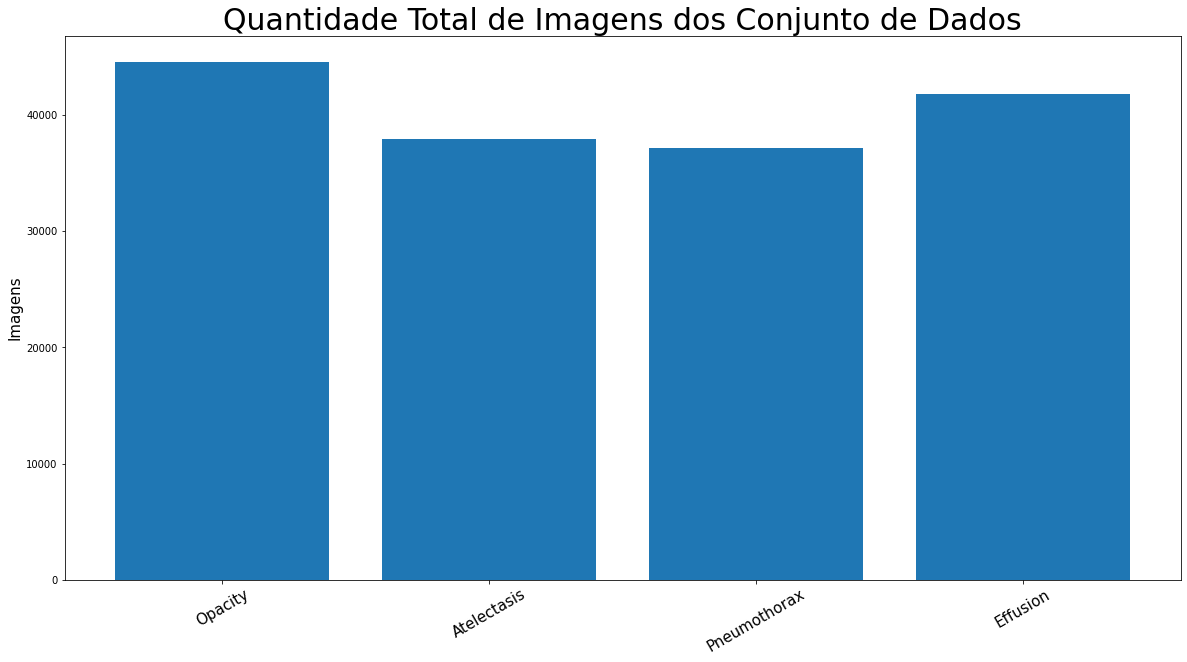

In [117]:
count_findings = list()
for finding in list(dataset.columns)[4:]:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(list(dataset.columns)[4:], count_findings)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

In [118]:
opacity = np.array(dataset['Opacity']).astype(str)
atelectasis = np.array(dataset['Atelectasis']).astype(str)
pneumothorax = np.array(dataset['Pneumothorax']).astype(str)
effusion = np.array(dataset['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset['labels_ref'] = all_labels

In [119]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['labels_ref'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                  stratify = f_val['labels_ref'])

In [122]:
f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

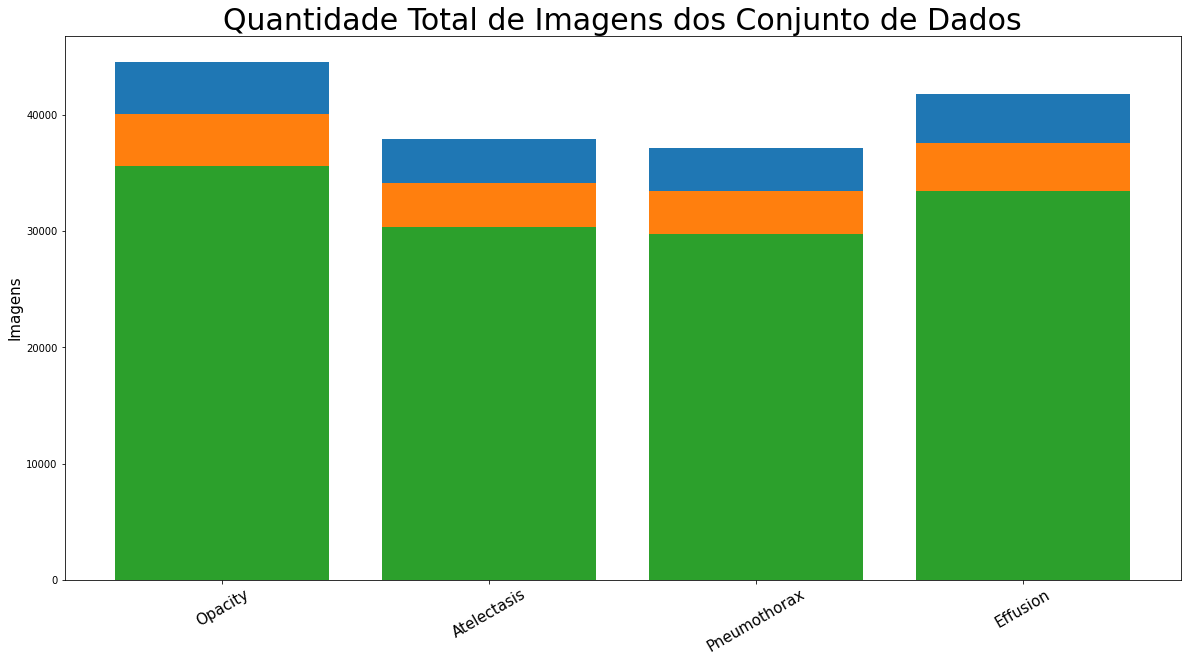

In [127]:
count_train, count_val, count_test = [], [], []
for finding in list(f_train.columns)[4:]:
  c_train = dict(f_train[finding].value_counts())[1.0]
  c_val = dict(f_val[finding].value_counts())[1.0]
  c_test = dict(f_test[finding].value_counts())[1.0]
  count_train.append(c_train), count_val.append(c_val), count_test.append(c_test)

plt.figure(figsize = (20, 10))
plt.bar(list(f_train.columns)[4:], np.sum((count_train, count_val, count_test), 
                                          axis = 0))
plt.bar(list(f_train.columns)[4:], np.sum((count_train, count_val), axis = 0))
plt.bar(list(f_train.columns)[4:], count_train)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

### Keras Data Generator

In [130]:
image_size, batch_size = 256, 32
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

In [131]:
core_idg = ImageDataGenerator(rescale = 1/255., 
                              shear_range = 0.1, zoom_range = 0.15,
                              rotation_range = 5, width_shift_range = 0.1, 
                              height_shift_range = 0.05, fill_mode = 'constant')

train_gen = core_idg.flow_from_dataframe(dataframe = f_train, directory = None, 
                                         x_col = 'Path', y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size))

core_idg = ImageDataGenerator(rescale = 1/255.)

valid_gen = core_idg.flow_from_dataframe(dataframe = f_val, directory = None, 
                                         x_col = 'Path',  y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe = f_test, 
                                                   directory = None, 
                                                   x_col = 'Path',
                                                   y_col = labels, 
                                                   class_mode = 'raw', 
                                                   batch_size = 2912,
                                                   target_size = (image_size, 
                                                                  image_size)))

Found 70159 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.


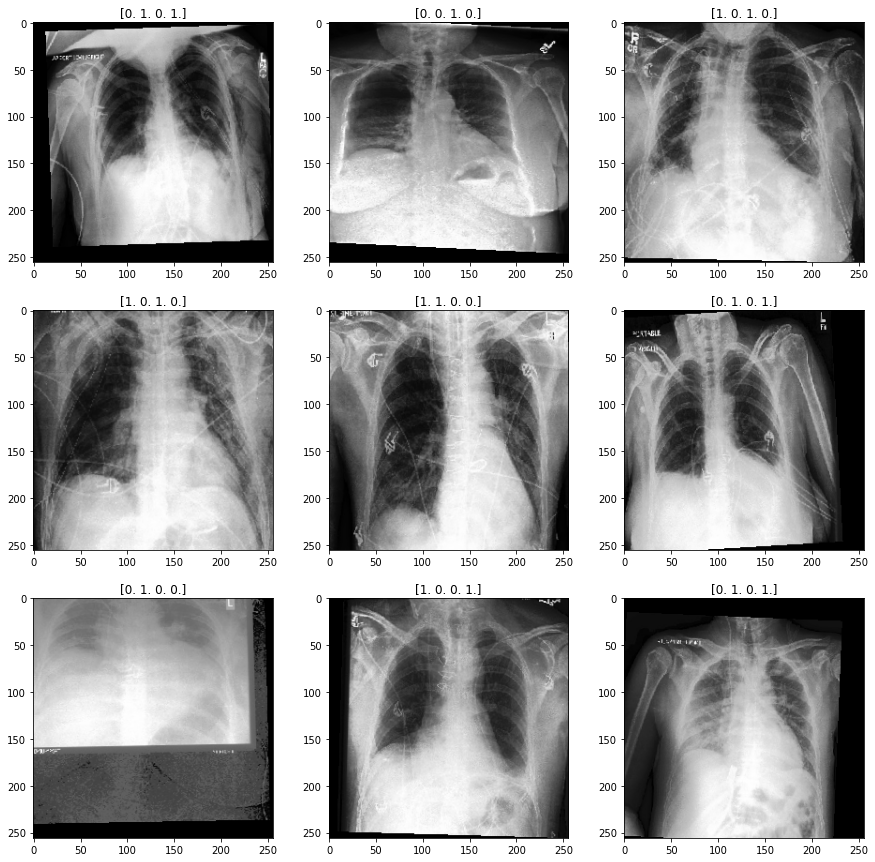

In [132]:
(x,y) = train_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count])
    count +=1

In [133]:
def get_callbacks(model_name, monitor = 'val_acc'):
    '''
    creates a list of useful callbacks for training the network

    Args:
        model_name (str) --> model name under review
        monitor (str) --> callback analysis metrics

    Returns:
        callbacks (list) --> callback list
    '''

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5',
                                                    verbose = 1, save_best_only = True, 
                                                    monitor = monitor, mode = 'max')
    
    return [checkpoint]

### DenseNet121

In [111]:
from tensorflow.keras.applications.densenet import DenseNet121 

In [ ]:
base_model = DenseNet121(include_top = False, weights = 'imagenet', 
                             input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
densenet = tf.keras.Model(base_model.input, output)
densenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                     loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                     metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('densenet', 'val_auc_7')
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data= valid_gen, epochs = 10, callbacks = callbacks,
             use_multiprocessing = True, workers = 4)

Epoch 1/10
2193/2192 [==============================] - ETA: 0s - loss: 0.6041 - auc_7: 0.7186
Epoch 1: val_auc_7 improved from -inf to 0.74281, saving model to model.densenet.h5
2192/2192 [==============================] - 1040s 466ms/step - loss: 0.6041 - auc_7: 0.7186 - val_loss: 0.6250 - val_auc_7: 0.7428
Epoch 2/10
2193/2192 [==============================] - ETA: 0s - loss: 0.5737 - auc_7: 0.7538
Epoch 2: val_auc_7 did not improve from 0.74281
2192/2192 [==============================] - 870s 395ms/step - loss: 0.5737 - auc_7: 0.7538 - val_loss: 0.8758 - val_auc_7: 0.6400
Epoch 3/10
2193/2192 [==============================] - ETA: 0s - loss: 0.5599 - auc_7: 0.7686
Epoch 3: val_auc_7 did not improve from 0.74281
2192/2192 [==============================] - 834s 379ms/step - loss: 0.5599 - auc_7: 0.7686 - val_loss: 0.6237 - val_auc_7: 0.7345
Epoch 4/10
2193/2192 [==============================] - ETA: 0s - loss: 0.5493 - auc_7: 0.7801
Epoch 4: val_auc_7 improved from 0.74281 to 0.

In [95]:
efficientnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            